In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_NAME
from pandas_profiling import ProfileReport
import pyarrow.feather as feather
import time
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

In [2]:
export_df = feather.read_feather("../data/cleaned_data.feather")

In [3]:
selected_columns = export_df[["event_timestamp","reaction_time","event_name","created_at","notif_viewed_ontime","published_at"]]
day_analisis = selected_columns.copy()

In [4]:
gpbyuser= export_df.groupby( by= ['user_id'])
gpbyuser2=gpbyuser.sum()
gpbyuser2['count1'] = gpbyuser.size()
gpbyuser2['opened_rate'] = gpbyuser2['opened']/gpbyuser2['count1']
gpbyuser2['ontime_activity_rate'] = gpbyuser2["notif_viewed_ontime"]/gpbyuser2['count1']
gpbyuser2.drop(gpbyuser2[gpbyuser2['count1'] <10 ].index, inplace=True)
real_users=gpbyuser2.index.tolist()
export_df=export_df[export_df['user_id'].isin(real_users)]

<AxesSubplot:xlabel='event_name', ylabel='count'>

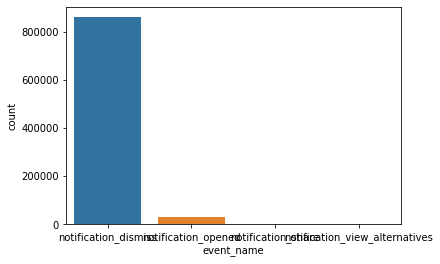

In [5]:
sns.countplot(data=export_df, x="event_name")

 # Analyzing agencies

In [6]:
#Deeper understanding on agencies. Choosing aggfunc sum, as we want to know how many users are affected by their notifications. Observing values for both active and unactive users, it does not matter, as this is addressed in another part.
agencies_by_cause = pd.pivot_table(export_df, values=['agency_GewRJAw5tUmC4Ku4AX1-SQ', 'agency_GtvOEQAFZ0GtU6u4AXwvPg','agency_HE59N3RXM0q5vKu4AXlQZg','agency_JUR9bFXmVkWDHqu4AXaY0g', 'agency_JfA8Bw8Zp024Kqu4AXiSpQ','agency_MgUq5b9mOEunx6u4AXt_BA','agency_NuuRQ2I1Q0a50Kv-AVKlLA', 'agency_V2AIQQKgmUO3VazvAOA-Cw','agency_jLjibFoim0iwWau4AWoEdQ', 'agency_pky7jovXYkaw-awAAMrQ3g',
'agency_zCy9zG00HEqGeKu4AWZYNQ'], index=['cause'], aggfunc=np.sum, fill_value=0, margins=True, margins_name= 'Total')
agencies_by_effect = pd.pivot_table(export_df, values=['agency_GewRJAw5tUmC4Ku4AX1-SQ', 'agency_GtvOEQAFZ0GtU6u4AXwvPg','agency_HE59N3RXM0q5vKu4AXlQZg','agency_JUR9bFXmVkWDHqu4AXaY0g', 'agency_JfA8Bw8Zp024Kqu4AXiSpQ','agency_MgUq5b9mOEunx6u4AXt_BA','agency_NuuRQ2I1Q0a50Kv-AVKlLA', 'agency_V2AIQQKgmUO3VazvAOA-Cw','agency_jLjibFoim0iwWau4AWoEdQ', 'agency_pky7jovXYkaw-awAAMrQ3g',
'agency_zCy9zG00HEqGeKu4AWZYNQ'], index=['effect'], aggfunc=np.sum, fill_value=0, margins=True, margins_name= 'Total')

In [7]:
#Agencies MgUq5b9mOEunx6u4AXt_BA and V2AIQQKgmUO3VazvAOA-Cw created no incidents, dropping them
agencies_by_effect.drop(["agency_MgUq5b9mOEunx6u4AXt_BA","agency_V2AIQQKgmUO3VazvAOA-Cw"],axis=1, inplace=True)
agencies_by_cause.drop(["agency_MgUq5b9mOEunx6u4AXt_BA","agency_V2AIQQKgmUO3VazvAOA-Cw"],axis=1, inplace=True)

 # Unactive users

In [8]:
export_df["notif_viewed_ontime"].value_counts()

1    515053
0    374563
Name: notif_viewed_ontime, dtype: int64

In [9]:
a = 524520/(526984+380595)
a


0.5779331606394594

 57,79% of notifications are viewed ontime.

<AxesSubplot:xlabel='ontime_activity_rate', ylabel='opened'>

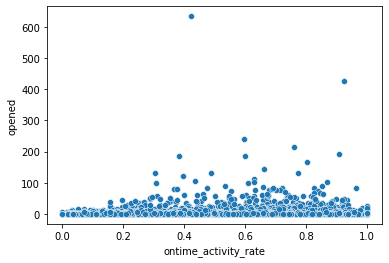

In [10]:
sns.scatterplot(data=gpbyuser2, y="opened", x="ontime_activity_rate")

<AxesSubplot:xlabel='opened_rate', ylabel='notif_viewed_ontime'>

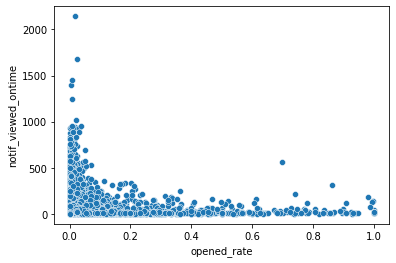

In [11]:
sns.scatterplot(data=gpbyuser2, x="opened_rate", y="notif_viewed_ontime")

<AxesSubplot:xlabel='opened_rate', ylabel='notif_viewed_notontime'>

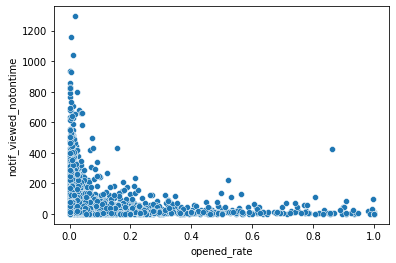

In [12]:
gpbyuser2["notif_viewed_notontime"]=gpbyuser2["count1"] - gpbyuser2["notif_viewed_ontime"] 
sns.scatterplot(data=gpbyuser2, x="opened_rate", y="notif_viewed_notontime")

<AxesSubplot:xlabel='reaction_time', ylabel='opened_rate'>

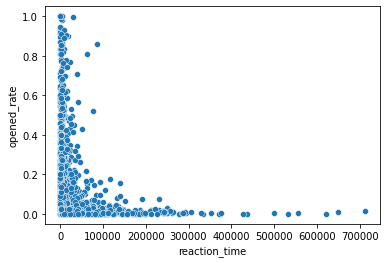

In [13]:
sns.scatterplot(data=gpbyuser2[["reaction_time","opened_rate"]], x= "reaction_time",y="opened_rate")

<AxesSubplot:xlabel='reaction_time', ylabel='opened_rate'>

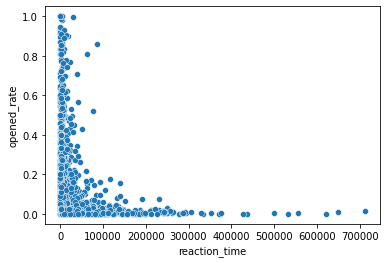

In [14]:
sns.scatterplot(data=gpbyuser2[["reaction_time","opened_rate"]], x= "reaction_time",y="opened_rate")

 Checking on incidents reacted late on

<AxesSubplot:xlabel='event_name', ylabel='count'>

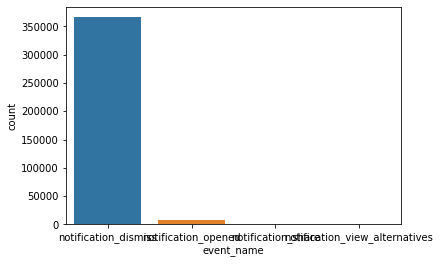

In [15]:
reacted_late_incidents=export_df[export_df["notif_viewed_ontime"]==0]
sns.countplot(data=reacted_late_incidents, x="event_name")


 # Identifying customers

In [16]:
agg_clust = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(gpbyuser2[["opened_rate", "ontime_activity_rate"]])

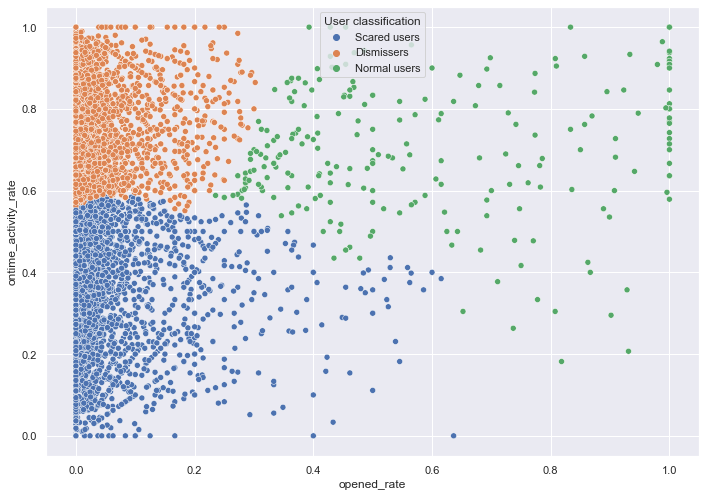

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax=sns.scatterplot(x=gpbyuser2["opened_rate"],y=gpbyuser2["ontime_activity_rate"], hue=agg_clust.labels_, palette="deep")
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ["Scared users","Dismissers","Normal users"],loc='upper center', title='User classification')

 # Identifying the time behaviour daily

 Excluding people who check their phone days later

In [18]:
day_analisis['reaction_hour'] = [row.hour for row in day_analisis['event_timestamp']]
day_analisis['notification_hour'] = [row.hour for row in day_analisis['created_at']]

In [19]:
#sns.scatterplot(data=day_analisis ,y="reaction_time",x="notification_hour",hue="event_name")

In [20]:
#sns.scatterplot(data=day_analisis ,y="reaction_time",x="reaction_hour",hue="event_name")

/Users/fortes/neuefische/Capstone-WIMT/.venv/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


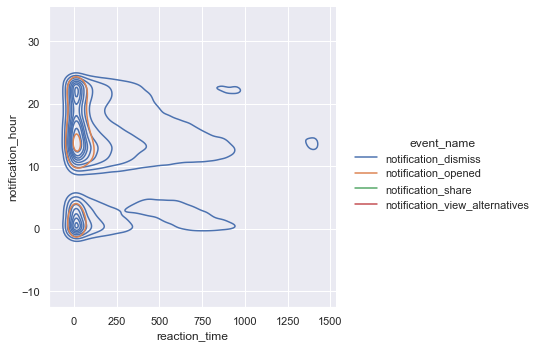

In [21]:
sns.displot(data=day_analisis, x ='reaction_time', y ='notification_hour', kind='kde', hue="event_name")


<AxesSubplot:xlabel='notification_hour', ylabel='reaction_time'>

/Users/fortes/neuefische/Capstone-WIMT/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


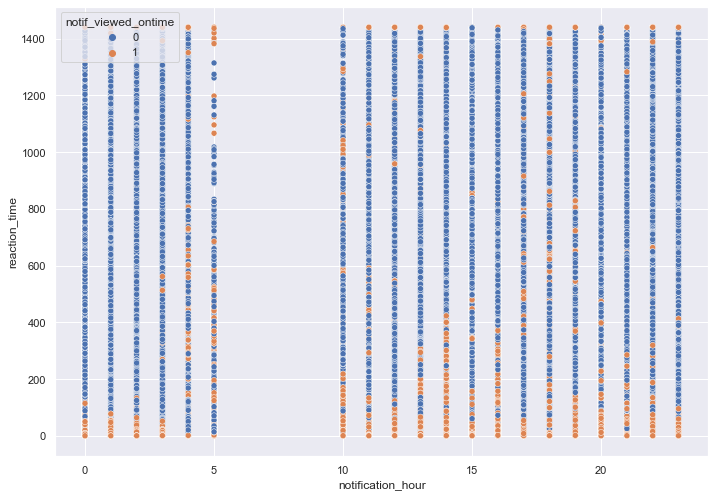

In [22]:
sns.scatterplot(data=day_analisis ,y="reaction_time",x="notification_hour",hue="notif_viewed_ontime")

In [23]:
export_df.shape

(889616, 27)